In [32]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [6]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df.shape

(5110, 12)

In [8]:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [9]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [10]:
df.isnull().sum()/len(df)*100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [11]:
df.dropna(inplace=True)

In [12]:
df.gender.value_counts()

gender
Female    2897
Male      2011
Other        1
Name: count, dtype: int64

In [13]:
obj_col = df.select_dtypes(include='object')
obj_col.nunique()

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

In [14]:
obj_col[(obj_col.gender != 'Male') & (obj_col.gender != 'Female')]

,gender,ever_married,work_type,Residence_type,smoking_status
3116,Other,No,Private,Rural,formerly smoked


In [15]:
df.drop(df[(df.gender!='Male') & (df.gender != 'Female')].index,inplace=True)

In [16]:
df.shape

(4908, 12)

In [17]:
target_equillibrium = df.stroke.value_counts()
target_equillibrium = pd.DataFrame(target_equillibrium)
print(f"The unbalanced state in terms of percentage, no-stroke: {round(target_equillibrium['count'][0]/len(df),2)*100}%, stroke: {round(target_equillibrium['count'][1]/len(df),2)*100}%")

The unbalanced state in terms of percentage, no-stroke: 96.0%, stroke: 4.0%


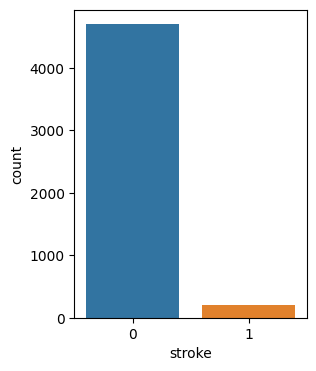

In [18]:
plt.figure(figsize=(3,4))
sns.barplot(data=target_equillibrium,x=target_equillibrium.index,y='count',)
plt.show();

In [19]:
to_encode = df.select_dtypes(include='object')
encode_columns = to_encode.columns
encode_columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [20]:
encode = OneHotEncoder(drop='first')
encoded_df = encode.fit_transform(df[encode_columns])

In [21]:
encoded_df = pd.DataFrame(encoded_df.toarray(),columns=encode.get_feature_names_out(encode_columns))

In [22]:
encoded_df

,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4903,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4904,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4905,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4906,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
numerical_data = (df.select_dtypes(exclude='object')).drop(columns = ['id','hypertension','heart_disease','stroke'])

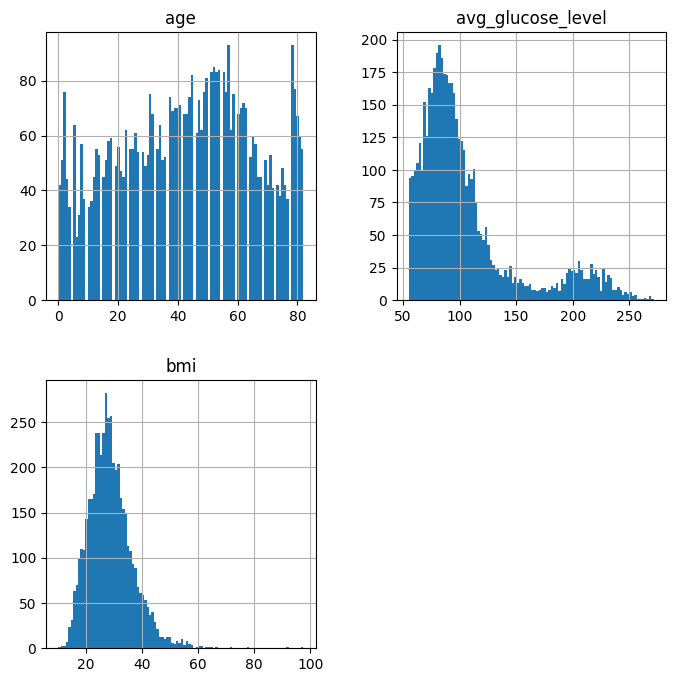

In [31]:
numerical_data.hist(bins=100,figsize=(8,8))
plt.show();

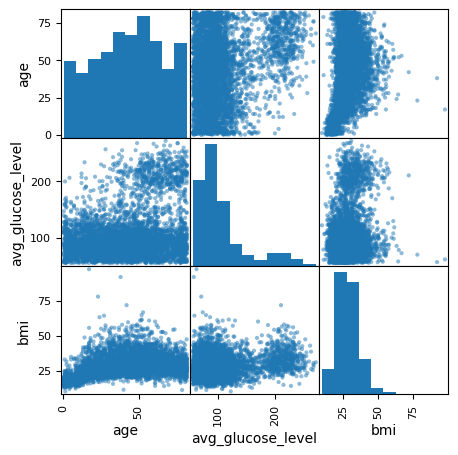

In [34]:
scatter_matrix(numerical_data,figsize=(5,5))
plt.show();